### 3. Generación de Lenguaje Natural
Implementación de un modelo de generación de lenguaje utilizando algún dataset de los propuestos de Twitter.

El objetivo es el de simular la creación de un bot que escriba tweets de manera similar al del autor utilizado para el entrenamiento.

Se valorará principalmente la argumentación de los pasos realizados y las conclusiones al analizar los resultados y limitaciones encontradas.

Esta práctica se ha realizado en colab por lo que hay algunas celdas que no funcionaran el jupyeter o algunas rutas que no se corresponden una estructura de un sistema normal


In [1]:
# Importamos a lo que vayamos a necesitar

import numpy as np
import pandas as pd
import re
import random
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib import cm

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#  connectamos con drive
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Cargamos los datos

In [3]:
# data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/KimKardashianTweets.csv')
data = pd.read_csv('./datasets/KimKardashianTweets.csv')

In [4]:
data.head()

,Unnamed: 0,date,id,link,retweet,text,author
0,0,Oct 2,782694393216110592,/KimKardashian/status/782694393216110592,False,Hey guys! Meet my #KimKardashianGame character...,KimKardashian
1,1,Oct 2,782632831780618240,/KimKardashian/status/782632831780618240,False,This guy is always in my shot!pic.twitter.com/...,KimKardashian
2,2,Oct 2,782559825205071872,/KimKardashian/status/782559825205071872,False,Balenciaga. No make up today.pic.twitter.com/l...,KimKardashian
3,3,Oct 1,782260907900567552,/KimKardashian/status/782260907900567552,False,Kourtney and Kim Take Parispic.twitter.com/VXw...,KimKardashian
4,4,Oct 1,782259209459101696,/KimKardashian/status/782259209459101697,False,GIVENCHY COUTUREpic.twitter.com/jHxTIuHzzo,KimKardashian


In [5]:
data = data[['retweet', 'text', 'author']]

In [6]:
data.head()

,retweet,text,author
0,False,Hey guys! Meet my #KimKardashianGame character...,KimKardashian
1,False,This guy is always in my shot!pic.twitter.com/...,KimKardashian
2,False,Balenciaga. No make up today.pic.twitter.com/l...,KimKardashian
3,False,Kourtney and Kim Take Parispic.twitter.com/VXw...,KimKardashian
4,False,GIVENCHY COUTUREpic.twitter.com/jHxTIuHzzo,KimKardashian


### Preprocesado

In [58]:
# Definimos unas regex que emplearemos para eliminar los siguientes campos:
#  - Usuarios/Menciones
#  - Hashtag
#  - Urls
#  - Imagenes

user_regex = re.compile('@\w+| @\w+ ')
hashtag_regex = re.compile('#\w+| #\w+ ')
url_regex = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
pics_regex = re.compile('pic?.\w+.\w+\/\w+')

rt_regex = re.compile('RT| RT ')

In [59]:
users = []
hashtags = []
urls = []
pics = []


texts = []
for text in data['text']:
    
    users.extend([it.strip()for it in user_regex.findall(text)])
    hashtags.extend([it.strip()for it in hashtag_regex.findall(text)])
    urls.extend([it.strip()for it in url_regex.findall(text)])
    pics.extend([it.strip()for it in pics_regex.findall(text)])
    
    aux = text
    aux = re.sub(pics_regex, '', aux)
    aux = re.sub(url_regex, '', aux) 
    aux = re.sub(user_regex.pattern, ' ', aux)
    aux = re.sub(hashtag_regex.pattern, ' ', aux)
    aux = re.sub(rt_regex.pattern, '', aux)

    aux = aux.replace(u'\xa0', u' ')

    aux = re.sub('-|=|<|>', '', aux)
    
    aux = aux.strip()

    texts.append(aux)

In [62]:
# Vemos como se ha quedado nuestro texto procesado
len(texts)

10688

In [63]:
# Combinamos los textos en una unica lista
text = r' '.join(texts)

In [64]:
#  Sacamos los caracteres que componen nuestro corpus
characters = sorted(list(set(text)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

print('Unique chars: {}'.format(len(characters)))

Unique chars: 118


In [65]:
print(characters)

['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\xad', '´', '¹', 'É', 'á', 'ã', 'é', 'ô', '\u200b', '\u200e', '\u200f', '–', '—', '‘', '’', '“', '”', '•', '…', '™', '♡', '♫', '\ue411', '\ue6b7', '\ue6b9', '\ue6e2', '\ue6e3', '\ue6eb']


###'Traducimos' nuestros datos a numero

In [66]:
# Definimos las constantes
window = 10

text = ' '.join(texts)

In [67]:
def text_conversion(text, ctn_dict, window=5, step=1):

    l = len(text) - window

    X = np.ndarray(shape=(l, window), dtype=int)
    
    Y = np.zeros(l, dtype=int)
    
    for i in range(0, l, step):
        sequence = text[i: i + window]
        label = text[i + window]
        
        X[i] =  np.asarray([ctn_dict[c] for c in sequence])
        Y[i] = ctn_dict[label]
        
    return X,Y

In [68]:
X, Y = text_conversion(text, char_to_n, window=window)

In [69]:
X_modified = np.reshape(X, (len(X), window, 1))
X_modified = X_modified / float(len(characters))
Y_modified = np_utils.to_categorical(Y)

In [70]:
Y_modified.shape

(690383, 118)

### Comenzamos con nuestro modelo

In [71]:
def plot_values(title, values, marker=None, plt=plt):
  cmap = cm.get_cmap('tab10', len(values))
  for i, (tit, vals) in enumerate(values):
    if marker:
      plt.plot(np.arange(0, len(vals)), vals, marker, color=cmap(i), label=tit)
    else: 
      plt.plot(np.arange(0, len(vals)), vals, color=cmap(i), label=tit)

  if hasattr(plt, 'xlabel'):
    plt.xlabel('Values #')
  else:
    plt.set_xlabel("Values #")

  if hasattr(plt, 'ylabel'):
    plt.ylabel(f"{title}")
  else:
    plt.set_ylabel(f"{title}")
  plt.legend()

In [72]:
def create_nlp_network(shape, otputs, weights=None):

  model = Sequential()

  model.add(LSTM(700, input_shape=shape, return_sequences=True))
  model.add(Dropout(0.2))
  
  model.add(LSTM(700))
  model.add(Dropout(0.2))

  model.add(Dense(Y_modified.shape[1], activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam')

  if weights:
    model.load_weights(weights)

  return model


In [74]:
# weights = './datasets/nlg_4.h5'

model = create_nlp_network(X_modified.shape[1:], Y_modified.shape[1])
# model = create_nlp_network(X_modified.shape[1:], Y_modified.shape[1], weights=weights )

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 700)           1965600   
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 700)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 700)               3922800   
_________________________________________________________________
dropout_8 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 118)               82718     
Total params: 5,971,118
Trainable params: 5,971,118
Non-trainable params: 0
_________________________________________________________________


In [76]:
history = model.fit(
    X_modified, Y_modified, 
    validation_split=0.05, 
    batch_size=256, 
    epochs=20).history

Train on 655863 samples, validate on 34520 samples
Epoch 1/20
655863/655863 [==============================] - 295s 450us/step - loss: 2.9359 - val_loss: 2.7735
Epoch 2/20
655863/655863 [==============================] - 295s 450us/step - loss: 2.6067 - val_loss: 2.4646
Epoch 3/20
655863/655863 [==============================] - 297s 453us/step - loss: 2.3430 - val_loss: 2.2717
Epoch 4/20
655863/655863 [==============================] - 299s 455us/step - loss: 2.1883 - val_loss: 2.1613
Epoch 5/20
655863/655863 [==============================] - 297s 453us/step - loss: 2.0838 - val_loss: 2.1000
Epoch 6/20
655863/655863 [==============================] - 297s 453us/step - loss: 2.0042 - val_loss: 2.0538
Epoch 7/20
655863/655863 [==============================] - 296s 452us/step - loss: 1.9368 - val_loss: 2.0303
Epoch 8/20
655863/655863 [==============================] - 298s 454us/step - loss: 1.8836 - val_loss: 2.0148
Epoch 9/20
655863/655863 [==============================] - 298s 455u

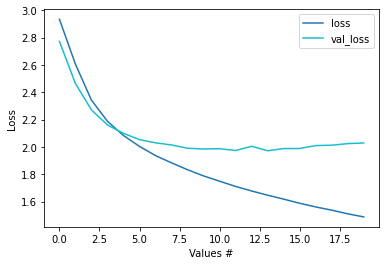

In [77]:
plot_values('Loss', [('loss', history['loss']), ('val_loss', history['val_loss'])])

In [78]:
def generate_text(model, initial_sequence):
    string_mapped = deepcopy(initial_sequence.tolist())
    full_string = [n_to_char[value] for value in string_mapped]
    
    # Generating characters
    # Generamos un tweet entre  280(el maximo actual de tweeter)
    characters_length = random.randint(len(string_mapped)+10, 280 )
    for i in range(characters_length):
        x = np.reshape(string_mapped,(1,len(string_mapped), 1))
        x = x / float(len(characters))

        pred_index = np.argmax(model.predict(x, verbose=0))
        seq = [n_to_char[value] for value in string_mapped]
        full_string.append(n_to_char[pred_index])

        string_mapped.append(pred_index)
        string_mapped = string_mapped[1:len(string_mapped)]
        
    text = ""
    for char in full_string:
        text = text + char
    return text

## Probemos a generar un tweet

In [79]:
generate_text(model, X[0])

'Hey guys! Love this pic of me and my sisters are to tweet  I was so excited to see it! '

Vemos que tiene 'cierto sentido' si se lee rapido, vamos a generar algunos tweets a partir de difenertes texto a ver si funciona bien

In [87]:
def generate_n_tweets(num_samples):
  for i in range(num_samples):
    txt = random.choice(texts)
    if len(txt) >= window:
      txt = txt[:window]
      chars = np.array([char_to_n[c] for c in txt])
      tweet = generate_text(model, chars)

      print(f'Tweet n {i}')
      print(f'Caracteres iniciales: \'{txt}\'')
      print(tweet)
      print()

In [91]:
generate_n_tweets(6)

Tweet n 0
Caracteres iniciales: 'Going to g'
Going to gave a good workout today  I love t guys  I love t guys  I love t guys  I love t guys  I love t guys  I love t guys  I 

Tweet n 1
Caracteres iniciales: 'Kylie is o'
Kylie is on tonight on E! at 9/8c! Shane you fave tome sertice and I are all ny family messages! ! I love you so much fun  The was so much fun  The was so much

Tweet n 2
Caracteres iniciales: 'What did y'
What did you guys think of the pione wes she real proud to she most googeous wieeo to she might with my baby is on tonight on E! at 9/8c! Shane you fave tome sertice and I are all ny family messages! ! I love you so much fun  The was so much fun  The was so much fun  The was s

Tweet n 3
Caracteres iniciales: 'BLACK FRID'
BLACK FRIDNDS TIITEDT TO MESE WOUED AARU TIITER SOINER SEIN FORN MOWE MOVE BARST MY SHAR FOR THIET What a fab cry but g

Tweet n 4
Caracteres iniciales: 'Another NY'
Another NYC alack & I will be at Darnes sesv much for the season finale of Kourtney 

Vemos que hay algunas extructuras que se repiten `I love t guys` y sobre todo ` I love`, también dado el tema de los tweets se observa que genera bien algunas palabras y otras que no tienen tanto sentido, por lo que podriamos entender que si se procesan un poco mas los datos o se obtienen mas datos con los que probar y mas tiempo podria ir un poco mas fino

In [89]:
# Ahora exportaremos nuestro modelo para poder reutilizarlo posteriormente
def export_modoel(model, name):
  model.save(f"{name}.h5")
  
  !cp {name}.h5 /content/drive/My\ Drive/Colab\ Notebooks/NLP/{name}.h5

  print("Saved model to disk")

In [90]:
export_modoel(model, 'nlg_4')

Saved model to disk


Como conclusiones de esta practica llego a que después de probar varios modelos depende mucho de el numero de epocas y del preprocesado que hagas obener un texto 'natral', basicamente mi proceso sobre esta pŕactica ha sido el de copiar una estructura básica e iterar sobre ella añadirndo etapas en la limpieza y cambiando los parametros del entrenamiento 'batch_size' y 'epochs'.

El reusltado final se ve que no es muy 'optimo' pero ha sido mucho tiempo y varias pruebas para intetar crar un mdelo que genre lenguaje 'natual'